# Data MC comparisons using the new simulations

https://wiki.icecube.wisc.edu/index.php/Simulation_and_Datasets_Used

In [1]:
import numpy as np
import pandas as pd
import nuflux
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16
# plt.rcParams['font.family'] = "serif"

In [3]:
LLH_DIFF = -0.1
Qst1 = 2000
Qst2 = 10
Qst3 = 10
RLOGL = 10

In [4]:
NOMINAL_PHI = 2.12
NOMINAL_GAMMA = 2.87
# NOMINAL_PHI = 2.04
# NOMINAL_GAMMA = 2.62
MG_SCALING = 2
LIVETIME = 305684668.46

In [5]:
sig_NET1 = 0.99
sig_NET2 = 0.98
sig_NET3 = 0.85

net3_val = 0.95
qasym_val = 0.05
outer_nums = np.array([75, 76, 77, 78, 72, 73, 74, 67, 59, 50, 40, 30, 21, 
                       13, 6, 5, 4, 3, 2, 1, 7, 14, 22, 31, 41, 51, 60, 68])

In [6]:
conv_flux = nuflux.makeFlux('honda2006').getFlux
prompt_flux = nuflux.makeFlux('H3a_SIBYLL23C_pr').getFlux

def weight_astro(astro_d, phi=NOMINAL_PHI, gamma=NOMINAL_GAMMA):
    en_weights = 1e-18 * phi * (astro_d.energy / 1e5)**(-gamma)
    return en_weights * astro_d.oneweight / astro_d.n_files / astro_d.n_events


def weight_atmos(atmos_d, flux):
    flux_weight = flux(atmos_d.pid.astype(np.int32), 
                       atmos_d.energy, 
                       atmos_d.coszen)
    
    denom = atmos_d.n_files * atmos_d.n_events * atmos_d.typeweight
    return flux_weight * atmos_d.oneweight / denom

In [7]:
mc_df = pd.read_hdf('nominal_new_sim_09_29_2021.h5', 'df')

# eliminate signal region from mc_df to enable comparisons with the blinded data
mc_df = mc_df[(mc_df.n1 < sig_NET1) | (mc_df.n2 < sig_NET2) | (mc_df.n3 < sig_NET3)].copy()

In [8]:
corsika_data = np.load('/fastio2/dasha/double_pulse/data_20904_corsika_test.npy')

# apply charge & containment cuts
cmask = corsika_data['qst']['q'][:, 0] > Qst1
cmask &= corsika_data['qst']['q'][:, 1] > Qst2
cmask &= corsika_data['qst']['q'][:, 2] > Qst3
cmask &= (~np.isin(corsika_data['qst']['num'][:, 0], outer_nums)) | (corsika_data['preds']['n3'] > net3_val)

corsika_data = corsika_data[cmask]

def remaining_corsika(net1, net2, net3):
    mask = corsika_data['preds']['n1'] > net1
    mask &= corsika_data['preds']['n2_1'] > net2
    mask &= corsika_data['preds']['n3'] > net3
    
    return corsika_data[mask]

In [9]:
data_getters = {"qtot": lambda a: a["qtot"],
                "llh_diff": lambda a: a["logan_veto"]["SPE_rlogl"] - a["logan_veto"]["Cascade_rlogl"],
                "spe_rlogl": lambda a: a["logan_veto"]["SPE_rlogl"],
                "qst0": lambda a: a["qst"]["q"][:, 0],
                "qst1": lambda a: a["qst"]["q"][:, 1],
                "qst2": lambda a: a["qst"]["q"][:, 2],
                "stnum0": lambda a: a["qst"]["num"][:, 0],
                "stnum1": lambda a: a["qst"]["num"][:, 1],
                "stnum2": lambda a: a["qst"]["num"][:, 2],
                "n1": lambda a: a["preds"]["n1"],
                "n2": lambda a: a["preds"]["n2"],
                "n3": lambda a: a["preds"]["n3"]}

In [10]:
# load data
data = np.load('/fastio2/dasha/double_pulse/data_data_2011-2020_2stage.npy')

data_df = pd.DataFrame({k: f(data) for k, f in data_getters.items()})
data_df["q_asym"] = 1 - data_df.qst0 / (data_df.qst0 + data_df.qst1 + data_df.qst2)
data_df.head()

,qtot,llh_diff,spe_rlogl,qst0,qst1,qst2,stnum0,stnum1,stnum2,n1,n2,n3,q_asym
0,10288.533203,-0.054070,7.540961,7623.043457,904.249878,611.807800,60,52,61,0.981077,0.010474,0.024837,0.165887
1,3673.876221,-0.057719,7.588037,3515.875977,32.198765,28.848898,59,50,67,0.968376,0.000371,0.097629,0.017067
2,2683.822510,3.731579,17.075340,2374.001953,31.239979,13.703360,30,39,40,0.595335,0.025770,0.162007,0.018580
3,2149.152832,0.290669,7.860095,2016.045410,17.576736,13.021856,61,68,62,0.845948,0.180564,0.683796,0.014951
4,2308.439453,0.157848,7.535373,2038.114258,69.630775,46.833252,67,58,59,0.695797,0.114395,0.235763,0.054054


### Apply preliminary cuts to the data

In [11]:
len(data_df)

65470

In [12]:
q_mask = (data_df.qst0 > Qst1) & (data_df.qst1 > Qst2) & (data_df.qst2 > Qst3)
rlogl_mask = (data_df.spe_rlogl < RLOGL)
llh_diff_mask = (data_df.llh_diff > LLH_DIFF)
data_df = data_df[q_mask & rlogl_mask & llh_diff_mask].copy()
len(data_df)

58402

In [13]:
def containment_mask(d, q_asym=True):
    if q_asym:
        or_cond = ((d.n3 > net3_val) & (d.q_asym > qasym_val))
    else:
        or_cond = (d.n3 > net3_val)
    
    return (~np.isin(d.stnum0, outer_nums)) | or_cond

### Make some plots for the near-background region

In [14]:
def build_net_mask(n1, n2, n3):
    return lambda d: (d.n1 > n1) & (d.n2 > n2) & (d.n3 > n3)

In [15]:
def total_weight(d, mg_scaling=MG_SCALING, phi=NOMINAL_PHI, gamma=NOMINAL_GAMMA,
                 conv=conv_flux, prompt=prompt_flux):
    out = np.zeros(len(d))
    
    mg_mask = d.pid == 0 # for muon gun
    
    # for muon gun, the one weight field stores the precalculated weight
    out[mg_mask] = mg_scaling * d[mg_mask].oneweight
    
    nu = d[~mg_mask]
    
    out[~mg_mask] = weight_astro(nu, phi, gamma) + weight_atmos(nu, conv) + weight_atmos(nu, prompt)
    
    return out

In [16]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

def data_mc_hists(n1, n2, n3, obsname, xlabel, bins, containment_mask=containment_mask):
    fig, ax = plt.subplots(figsize=(12, 5))

    net_mask = build_net_mask(n1, n2, n3)
    sig_mask = (np.abs(mc_df.pid) == 16) & (mc_df.it == 1)
    labels = ['MC expectation', r'astrophysical $\nu_\tau$ CC', 'data']
    colors = [None, None, 'k']
    weights = [total_weight, weight_astro, lambda _: None]
    
    for df, weight, label, color in zip([mc_df, mc_df[sig_mask], data_df], 
                                        weights, labels, colors):
        df = df[net_mask][containment_mask]
        
        weight = weight(df)
        if weight is not None:
            weight *= LIVETIME

        hist = np.histogram(df[obsname], bins=bins, weights=weight)[0]
        if 'expectation' in label:
            mc_var = np.histogram(df[obsname], bins=bins, weights=weight**2)[0]
            total_err = np.sqrt(mc_var + hist)
            ax.fill_between(bins, np.hstack([hist + total_err, [0]]), 
                            np.hstack([hist - total_err, [0]]), 
                            step='post', color=color_cycle[0], 
                            alpha=0.5, label='total uncertainty')

        if label != 'data':
            l = ax.step(bins, np.hstack([hist, 0]), where='post', 
                        color=color, label=label)[0]
        else:
            ax.plot(0.5 * (bins[1:] + bins[:-1]), hist, 'ko', 
                    label=label, markersize=10)

    net_cuts = (n1, n2, n3)
    title = ''
    for i in range(3):
        title += f'NET{i + 1} > {net_cuts[i]}, '
        
    title += 'signal region excluded'
    
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel("number of events")
    ax.set_title(title)
    
    ax.set_xlim(bins[0], bins[-1])
    
    return ax

def net_hist_plot(n1, n2, n3, net, net_bins):
      return data_mc_hists(n1, n2, n3, f"n{net}", f"NET{net}", net_bins) 

def calc_cumulative(df, net, net_bins, weight_func=None, livetime=LIVETIME):
    if weight_func is not None:
        hist = np.histogram(df[f'n{net}'], net_bins, weights=weight_func(df) * livetime)[0]
        var_hist = np.histogram(df[f'n{net}'], net_bins, weights=weight_func(df)**2 * livetime**2)[0]
    else:
        hist = np.histogram(df[f'n{net}'], net_bins)[0]
        var_hist = np.histogram(df[f'n{net}'], net_bins)[0]
        
    return np.hstack([np.cumsum(hist[::-1])[::-1], [0]]), np.hstack([np.cumsum(var_hist[::-1])[::-1], [0]])
    
    
def cumulative_plot(n1, n2, n3, net, net_bins):
    net_mask = build_net_mask(n1, n2, n3)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    mc = mc_df[net_mask][containment_mask]
    total_exp, mc_var = calc_cumulative(mc, net, net_bins, total_weight)
    
    
    total_err = np.sqrt(mc_var + total_exp)
    ax.fill_between(net_bins, total_exp + total_err, total_exp - total_err, alpha=0.5, 
                    label='total uncertainty')
    mc_err = np.sqrt(mc_var)
    ax.fill_between(net_bins, total_exp + mc_err, total_exp - mc_err, alpha=0.8, 
                    label='MC uncertainty')
    ax.plot(net_bins, total_exp, '--', label='total sim', zorder=5)
        
    sig_mask = (np.abs(mc.pid) == 16) & (mc.it == 1)
    mg_mask = mc.pid == 0
    nu_mask = ~mg_mask
    astro_bg_mask = nu_mask & ~(sig_mask)
    atmos_weight = lambda d: weight_atmos(d, conv_flux) + weight_atmos(d, prompt_flux)
    mg_weight = lambda d: d.oneweight * MG_SCALING
    
    masks = (sig_mask, astro_bg_mask, nu_mask, mg_mask)
    weights = (weight_astro, weight_astro, atmos_weight, mg_weight)
    labels = (r'astrophysical $\nu_\tau$ CC', 'astrophysical bg', 'atmospheric bg', 'muon gun')
    for mask, weight, label in zip(masks, weights, labels):
        total, _ = calc_cumulative(mc[mask], net, net_bins, weight)
        ax.plot(net_bins, total, '-', label=label)
    
    data, _ = calc_cumulative(data_df[net_mask][containment_mask], net, net_bins)
    ax.plot(net_bins, data, 'ko', label='data', zorder=6)

    title = ''
    net_cuts = (n1, n2, n3)
    for i in range(3):
        if i + 1 != net:
            title += f'NET{i + 1} > {net_cuts[i]}, '
    title += 'signal region excluded'
    
    ax.set_title(title)
    
    ax.legend()
    ax.set_xlabel(f"NET{net} cut")
    ax.set_ylabel("number of events")
    ax.set_xlim(net_bins[0], net_bins[-1])
    
    return ax

# Net Scores

array([], shape=(0, 3),
      dtype=[('q', '<f4'), ('num', '<u4'), ('dist', '<f4')])

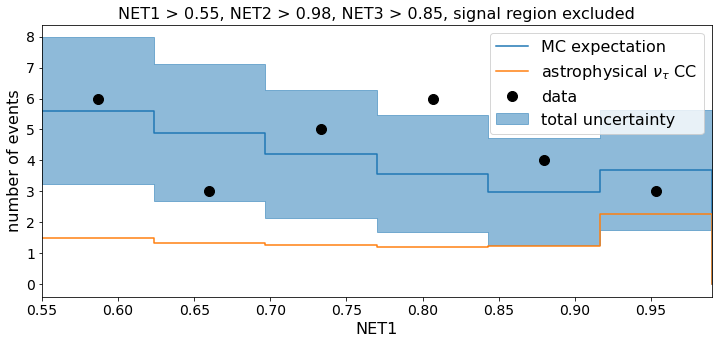

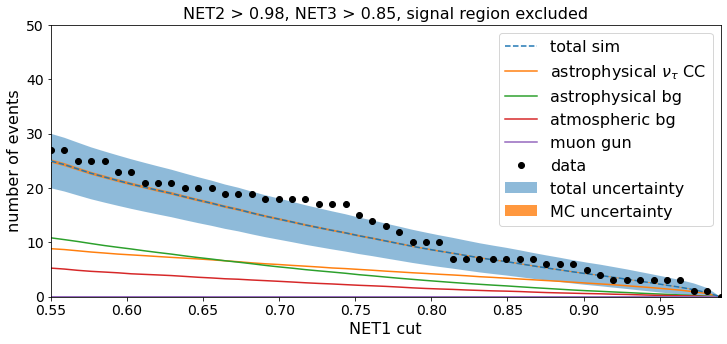

In [17]:
n1_cut = 0.55
n2_cut = 0.98
n3_cut = 0.85

net_bins = np.linspace(0.55, 0.99, 7)
ax1 = net_hist_plot(n1_cut, n2_cut, n3_cut, 1, net_bins)
plt.gcf().savefig('data_mc_plots/net1_hist.png', bbox_inches='tight')
ax2 = cumulative_plot(n1_cut, n2_cut, n3_cut, 1, np.linspace(0.55, 0.99, 51))
ax2.set_ylim(0, 50)
plt.gcf().savefig('data_mc_plots/net1_cumulative.png', bbox_inches='tight')

remaining_corsika(n1_cut, n2_cut, n3_cut)['qst']

array([], shape=(0, 3),
      dtype=[('q', '<f4'), ('num', '<u4'), ('dist', '<f4')])

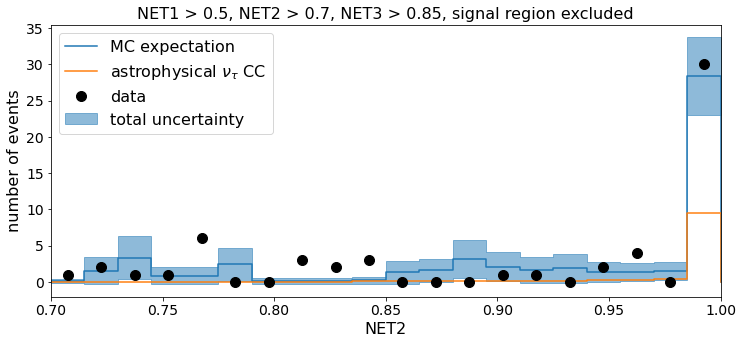

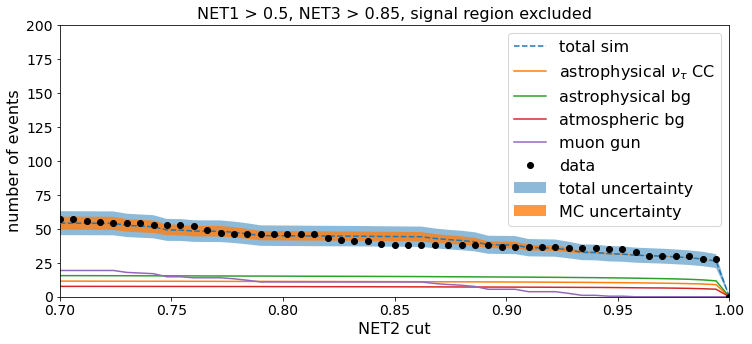

In [18]:
n1_cut = 0.5
n2_cut = 0.7
n3_cut = 0.85

net_bins = np.linspace(0.7, 1, 21)
ax = net_hist_plot(n1_cut, n2_cut, n3_cut, 2, net_bins)
plt.gcf().savefig('data_mc_plots/net2_hist.png', bbox_inches='tight')

ax2 = cumulative_plot(n1_cut, n2_cut, n3_cut, 2, np.linspace(0.7, 1, 51))
ax2.set_ylim(0, 200)
plt.gcf().savefig('data_mc_plots/net2_cumulative.png', bbox_inches='tight')
remaining_corsika(n1_cut, n2_cut, n3_cut)['qst']

array([], shape=(0, 3),
      dtype=[('q', '<f4'), ('num', '<u4'), ('dist', '<f4')])

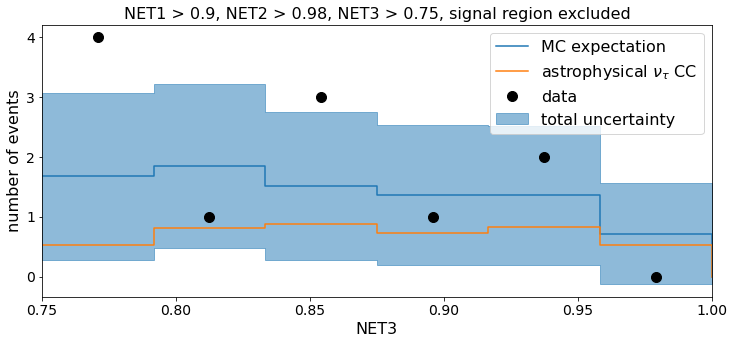

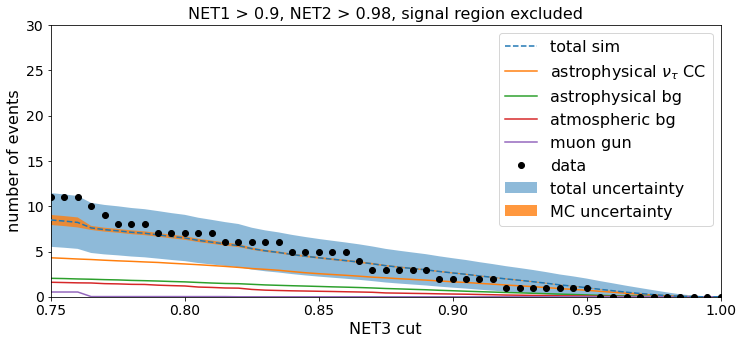

In [19]:
n1_cut = 0.9
n2_cut = 0.98
n3_cut = 0.75

net_bins = np.linspace(0.75, 1, 7)
ax = net_hist_plot(n1_cut, n2_cut, n3_cut, 3, net_bins)
plt.gcf().savefig('data_mc_plots/net3_hist.png', bbox_inches='tight')

ax2 = cumulative_plot(n1_cut, n2_cut, n3_cut, 3, np.linspace(n3_cut, 1, 51))
ax2.set_ylim(0, 30)
plt.gcf().savefig('data_mc_plots/net3_cumulative.png', bbox_inches='tight')
remaining_corsika(n1_cut, n2_cut, n3_cut)['qst']

### 2D NET1 / NET3 plot

total expected: 13.801214822107344
total seen: 17


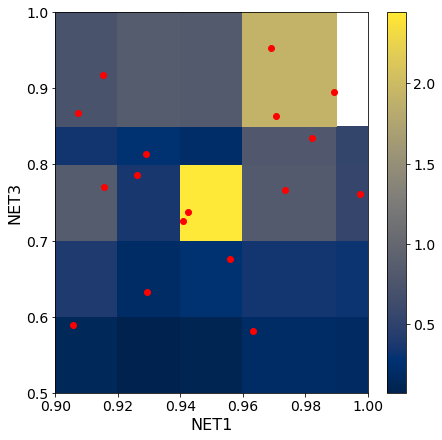

In [20]:
net1_min = 0.9
net2_cut = 0.98
net3_min = 0.5

net2_mask = lambda d: d.n2 >= net2_cut

n_bins = 5
bins_x = np.linspace(net1_min, 1.0, n_bins + 1)
bins_x[-2] = sig_NET1
bins_y = np.linspace(net3_min, 1.0, n_bins + 1)
bins_y[-2] = sig_NET3
exp_df = mc_df[net2_mask][containment_mask]
exp_hist = np.histogram2d(exp_df.n1, exp_df.n3, bins=(bins_x, bins_y), weights=total_weight(exp_df)*LIVETIME)[0]
masked_hist = np.ma.masked_where(exp_hist == 0, exp_hist)
fig, ax = plt.subplots(figsize=(7, 7))

m = ax.pcolormesh(bins_x, bins_y, masked_hist.T, rasterized=True, cmap='cividis')
plt.colorbar(m)
ax.set_xlabel('NET1')
ax.set_ylabel('NET3')

net_mask = build_net_mask(net1_min, net2_cut, net3_min)
data_evts = data_df[net_mask][containment_mask]
ax.plot(data_evts.n1, data_evts.n3, 'ro')
print(f"total expected: {exp_hist.sum()}")
print(f"total seen: {len(data_evts)}")

# String positions and $Q_{asym}$, $Q_{tot}$, LLH diff, SPE rlogl

In [21]:
import json
with open('position_map.json') as f:
    pos_df = pd.DataFrame(json.load(f))
    # only consider underground doms
pos_df = pd.DataFrame(pos_df[pos_df.z < 1500])
string_df = pos_df.groupby('string').mean()
string_df.head()

,y,x,om,z
string,,,,
1,-521.080017,-256.140015,30.5,-6.018667
2,-501.450012,-132.800003,30.5,-2.037833
3,-481.739990,-9.130000,30.5,-2.877834
4,-461.989990,114.389999,30.5,-3.447833
5,-442.420013,237.779999,30.5,-0.647833


In [22]:
def data_mc_stpos(data_df, mc_df, stkey='stnum0'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(hspace=0.25)

    # add the first point back to complete the loop    
    hull_pts = np.hstack([outer_nums, outer_nums[0]])
    hull_df = string_df.loc[hull_pts]

    mc_df['total_weight'] = total_weight(mc_df) * LIVETIME
    print(mc_df.total_weight.sum())
    
    counts_mc = mc_df.groupby(stkey)[['total_weight']].sum()
    counts_mc *= 100.0 / counts_mc.max()
    
    counts_data = data_df.groupby(stkey)[['spe_rlogl']].count()
    print(counts_data.sum())
    counts_data *= 100.0 / counts_data.max()
    counts_data['total_weight'] = counts_data['spe_rlogl']
    
    for ax, df, label in zip(axes.flat, (counts_mc, counts_data), ('expected', 'data')):      
        if label == 'expected':
            exp = mc_df['total_weight'].sum()
            mc_var = (mc_df['total_weight']**2).sum() 
            err = np.sqrt(exp + mc_var)
            label += f': {exp:.0f} $\pm$ {err:.0f} events'
        else:
            label += f': {len(data_df)} events'
            
        ax.set_title(label, fontsize=16)
        ax.set_xlim(-650, 650)
        ax.set_ylim(-650, 650)

        ax.plot(hull_df.x, hull_df.y, 'b--', alpha=0.5)

        ax.scatter(string_df.loc[df.index].x, string_df.loc[df.index].y, 
                    s=df.total_weight, alpha=1, color='red')
        
#         dc = string_df[string_df.index >= 79]
#         ax.plot(dc.x, dc.y, 'gx')
        
        ax.tick_params(labelsize=14)
        
    axes[0].set_ylabel('y (m)', fontsize=16)
    axes[0].set_xlabel('x (m)', fontsize=16)
    axes[1].set_xlabel('x (m)', fontsize=16)

In [23]:
on_outer_str = lambda d: np.isin(d.stnum0, outer_nums)

In [25]:
q_asym_bins = np.linspace(0, 2/3.0, 11)
qtot_bins = np.logspace(3.3, 5, 11)
llh_diff_bins = np.linspace(-0.1, 0.6, 11)
rlogl_bins = np.linspace(6, 10, 21)

54.51637632276824
spe_rlogl    63
dtype: int64
expected on outer string: 1.0193400106095019
observed on an outer string: 6
p value: 0.0006558089952601875


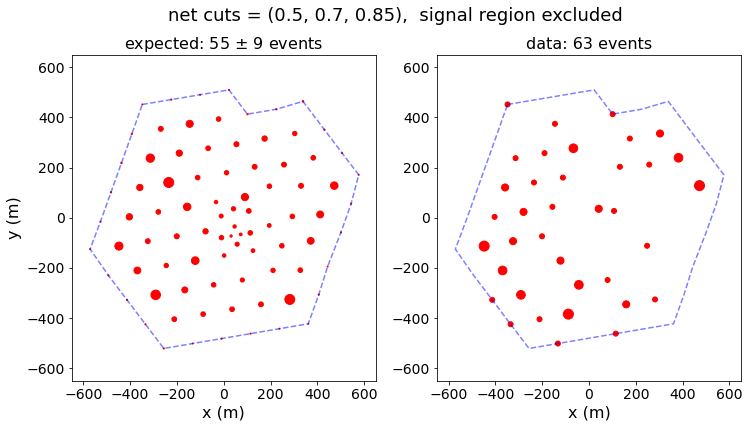

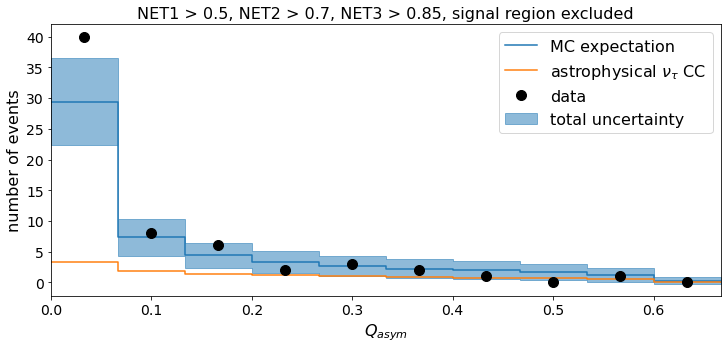

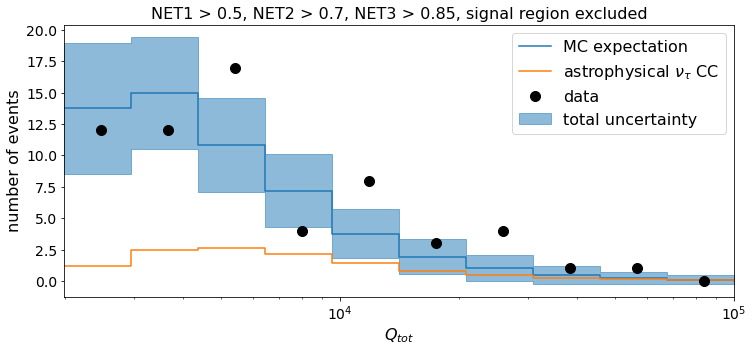

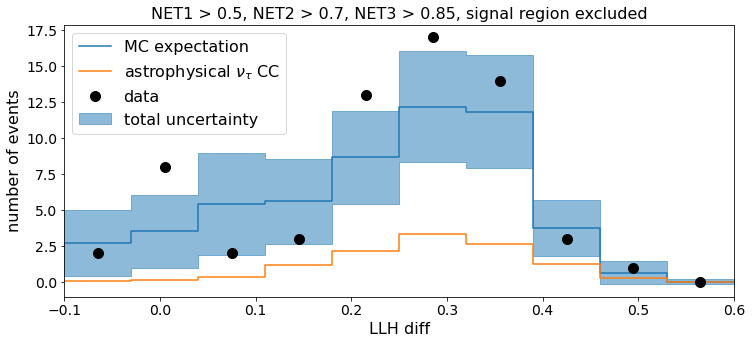

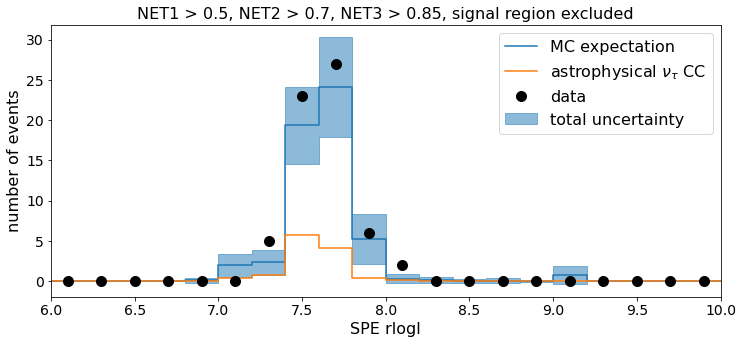

In [26]:
net_cuts = (0.5, 0.7, 0.85)
net_mask = build_net_mask(*net_cuts)
no_qasym_mask = lambda d: containment_mask(d, False)
data_mc_stpos(data_df[net_mask][no_qasym_mask].copy(), mc_df[net_mask][no_qasym_mask].copy())
plt.gcf().suptitle(f'net cuts = {net_cuts},  signal region excluded', fontsize=18, y=0.99)
plt.gcf().savefig('string_pos_no_q_asym.png', bbox_inches='tight')

exp_outer = total_weight(mc_df[net_mask][no_qasym_mask][on_outer_str]).sum()*LIVETIME
obs_outer = len(data_df[net_mask][no_qasym_mask][on_outer_str])
print(f"expected on outer string: {exp_outer}")
print(f"observed on an outer string: {obs_outer}")

poisson = stats.poisson(exp_outer)
p_val = 1 - sum(poisson.pmf(i) for i in range(obs_outer))
print(f"p value: {p_val}")

data_mc_hists(*net_cuts, 'q_asym', '$Q_{asym}$', q_asym_bins, no_qasym_mask)

ax = data_mc_hists(*net_cuts, 'qtot', '$Q_{tot}$', qtot_bins, no_qasym_mask)
ax.set_xscale('log')
_ = data_mc_hists(*net_cuts, 'llh_diff', 'LLH diff', llh_diff_bins, no_qasym_mask)
_ = data_mc_hists(*net_cuts, 'spe_rlogl', 'SPE rlogl', rlogl_bins, no_qasym_mask)

### Find the outer string events:

In [27]:
outer_evts = data_df[net_mask][no_qasym_mask][on_outer_str]

outer_evts

,qtot,llh_diff,spe_rlogl,qst0,qst1,qst2,stnum0,stnum1,stnum2,n1,n2,n3,q_asym
5225,9430.441406,0.237900,7.533209,8766.382812,198.011902,165.691986,2,8,9,0.865977,1.000000,0.967794,0.039836
9242,12936.166992,-0.012242,7.563162,12783.263672,40.917263,17.738676,7,14,8,0.864126,0.737257,0.980234,0.004568
12231,2676.173096,0.258680,7.873606,2561.394775,17.115761,14.324286,14,15,22,0.738285,0.986178,0.953457,0.012126
32626,21252.966797,0.132547,7.521336,21052.503906,32.536537,29.638014,72,65,64,0.553036,0.988672,0.972452,0.002945
47738,6174.852051,0.186757,7.398496,5833.534180,147.176910,82.696724,75,69,76,0.965767,0.999992,0.973645,0.037912
55732,5355.774902,0.221745,7.519333,4981.262695,125.994057,77.229332,4,10,11,0.720396,0.946351,0.961018,0.039198


54.181102878771895
spe_rlogl    57
dtype: int64
expected on outer string: 0.6840665666131612
observed on an outer string: 0
p value: 1
prob 0: 0.5045609838998113
54.181102878771895
spe_rlogl    57
dtype: int64


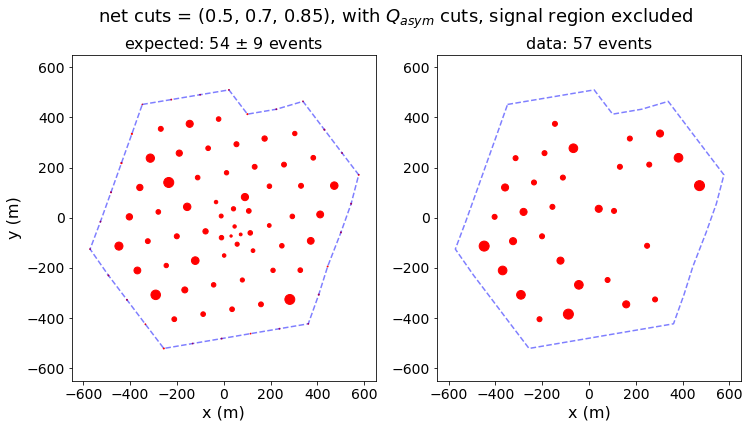

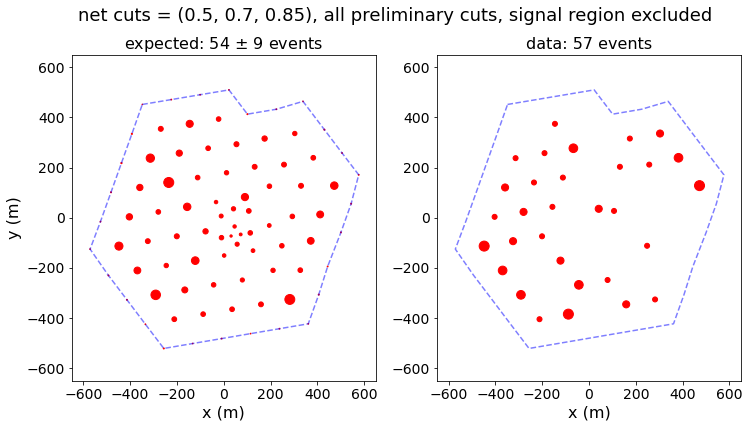

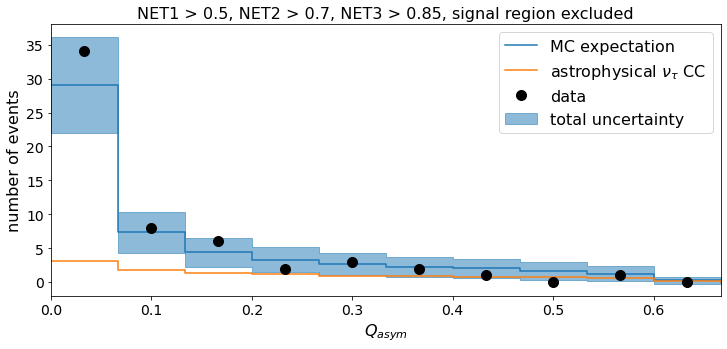

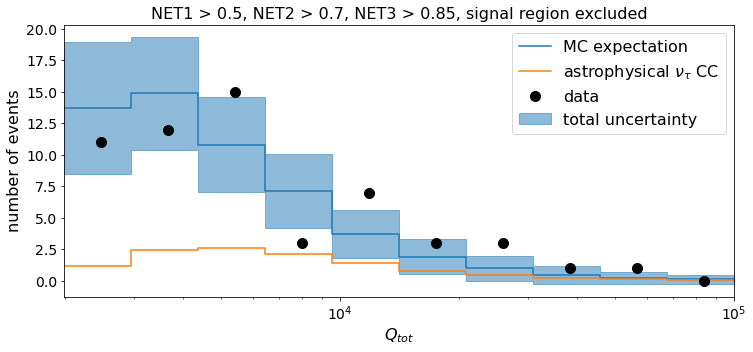

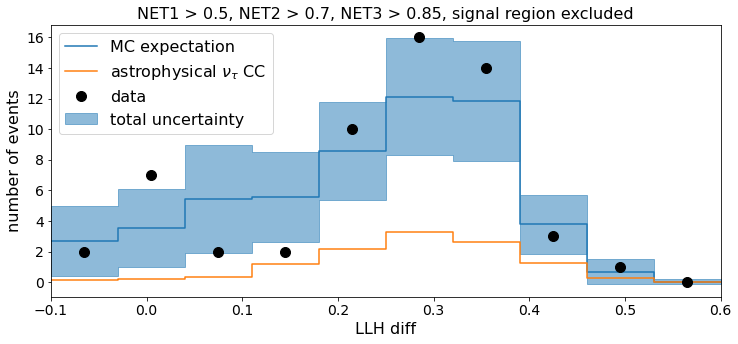

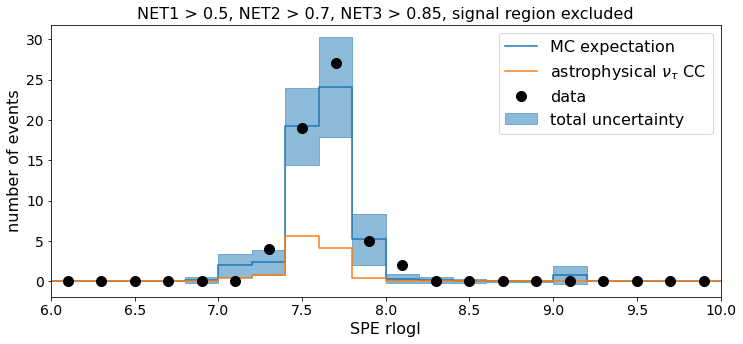

In [28]:
net_cuts = (0.5, 0.7, 0.85)
net_mask = build_net_mask(*net_cuts)
data_mc_stpos(data_df[net_mask][containment_mask].copy(), mc_df[net_mask][containment_mask].copy())
plt.gcf().suptitle(f'net cuts = {net_cuts}, with $Q_{{asym}}$ cuts, signal region excluded', fontsize=18, y=0.99)
plt.gcf().savefig('string_pos_with_q_asym.png', bbox_inches='tight')

exp_outer = total_weight(mc_df[net_mask][containment_mask][on_outer_str]).sum()*LIVETIME
obs_outer = len(data_df[net_mask][containment_mask][on_outer_str])
print(f"expected on outer string: {exp_outer}")
print(f"observed on an outer string: {obs_outer}")

poisson = stats.poisson(exp_outer)
p_val = 1 - sum(poisson.pmf(i) for i in range(obs_outer))
print(f"p value: {p_val}")
print(f"prob 0: {poisson.pmf(0)}")

data_mc_stpos(data_df[net_mask][containment_mask].copy(), mc_df[net_mask][containment_mask].copy())
plt.gcf().suptitle(f'net cuts = {net_cuts}, all preliminary cuts, signal region excluded', fontsize=18, y=0.99)
plt.gcf().savefig('data_mc_plots/net2_positions.png', bbox_inches='tight')


data_mc_hists(*net_cuts, 'q_asym', '$Q_{asym}$', q_asym_bins, containment_mask)
plt.gcf().savefig('data_mc_plots/net2_qasym.png', bbox_inches='tight')
ax = data_mc_hists(*net_cuts, 'qtot', '$Q_{tot}$', qtot_bins, containment_mask)
ax.set_xscale('log')
plt.gcf().savefig('data_mc_plots/net2_qtot.png', bbox_inches='tight')
_ = data_mc_hists(*net_cuts, 'llh_diff', 'LLH diff', llh_diff_bins, containment_mask)
plt.gcf().savefig('data_mc_plots/net2_llh_diff.png', bbox_inches='tight')
_ = data_mc_hists(*net_cuts, 'spe_rlogl', 'SPE rlogl', rlogl_bins, containment_mask)
plt.gcf().savefig('data_mc_plots/net2_spe_rlogl.png', bbox_inches='tight')

24.975996050064012
spe_rlogl    27
dtype: int64


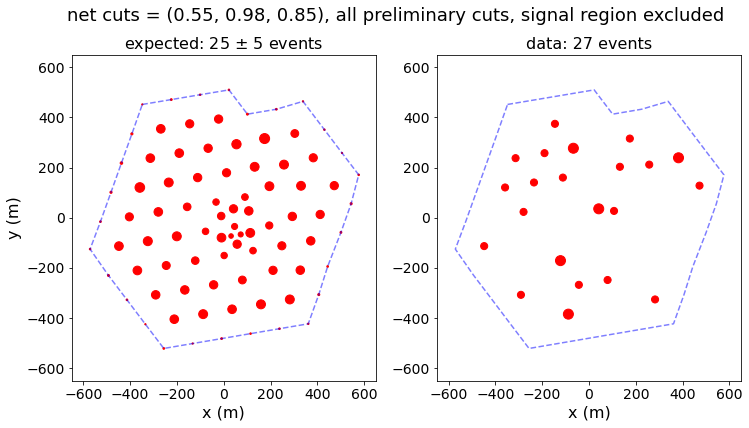

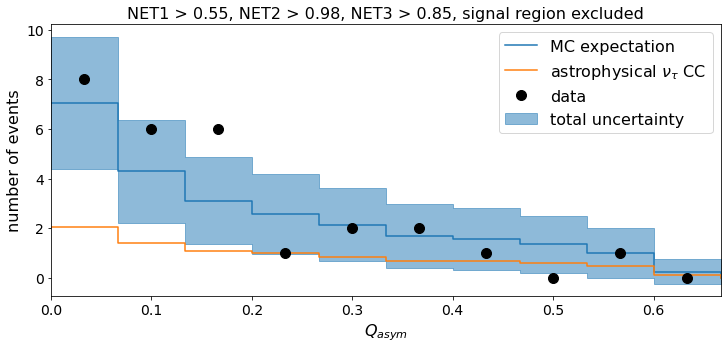

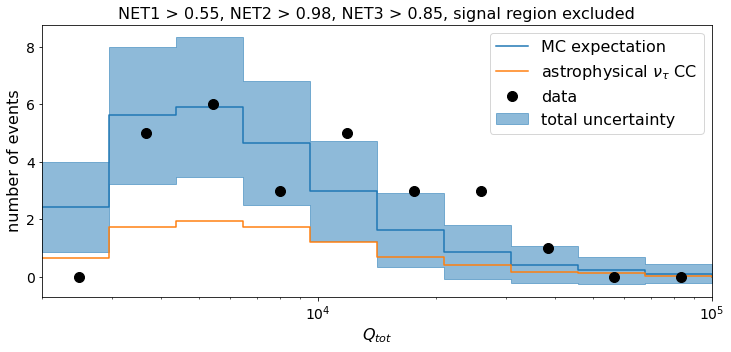

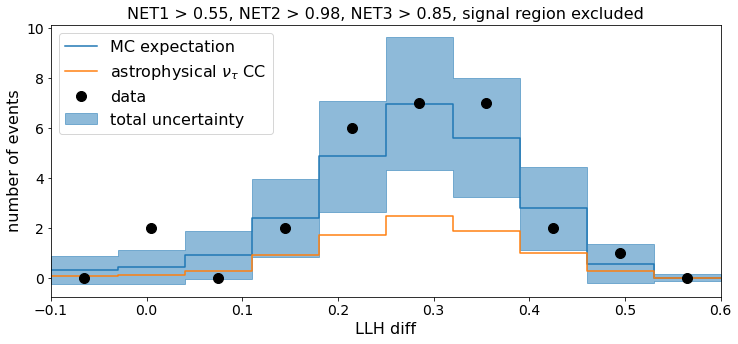

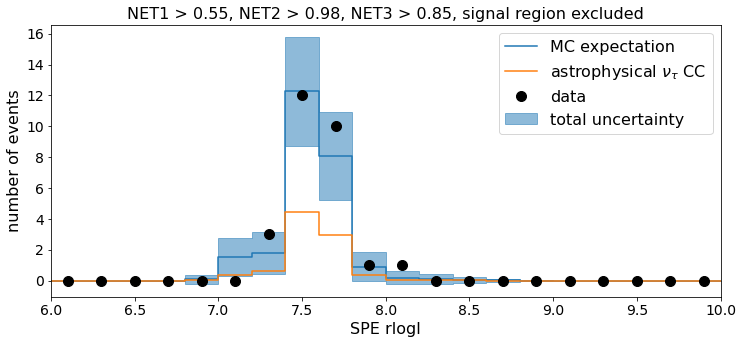

In [29]:
net_cuts = (0.55, 0.98, 0.85)
net_mask = build_net_mask(*net_cuts)
data_mc_stpos(data_df[net_mask][containment_mask], mc_df[net_mask][containment_mask])
plt.gcf().suptitle(f'net cuts = {net_cuts}, all preliminary cuts, signal region excluded', fontsize=18, y=0.99)
plt.gcf().savefig('data_mc_plots/net1_positions.png', bbox_inches='tight')
data_mc_hists(*net_cuts, 'q_asym', '$Q_{asym}$', q_asym_bins, containment_mask)
plt.gcf().savefig('data_mc_plots/net1_qasym.png', bbox_inches='tight')
ax = data_mc_hists(*net_cuts, 'qtot', '$Q_{tot}$', qtot_bins, containment_mask)
ax.set_xscale('log')
plt.gcf().savefig('data_mc_plots/net1_qtot.png', bbox_inches='tight')
_ = data_mc_hists(*net_cuts, 'llh_diff', 'LLH diff', llh_diff_bins, containment_mask)
plt.gcf().savefig('data_mc_plots/net1_llh_diff.png', bbox_inches='tight')
_ = data_mc_hists(*net_cuts, 'spe_rlogl', 'SPE rlogl', rlogl_bins, containment_mask)
plt.gcf().savefig('data_mc_plots/net1_spe_rlogl.png', bbox_inches='tight')


8.479739983296607
spe_rlogl    11
dtype: int64


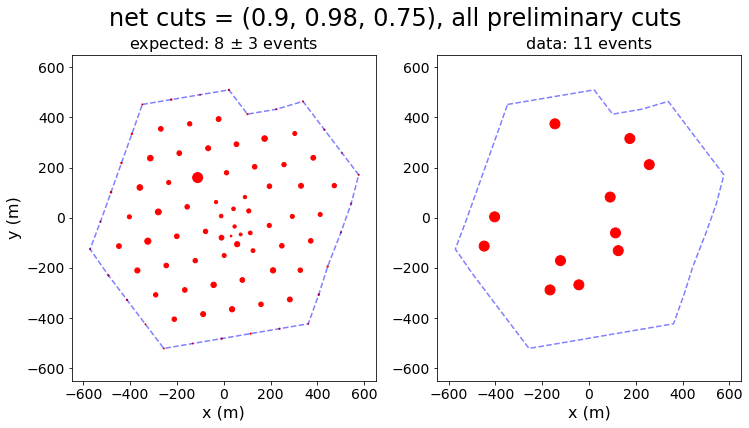

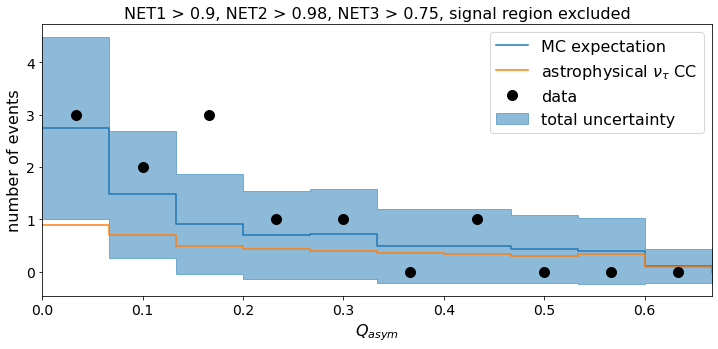

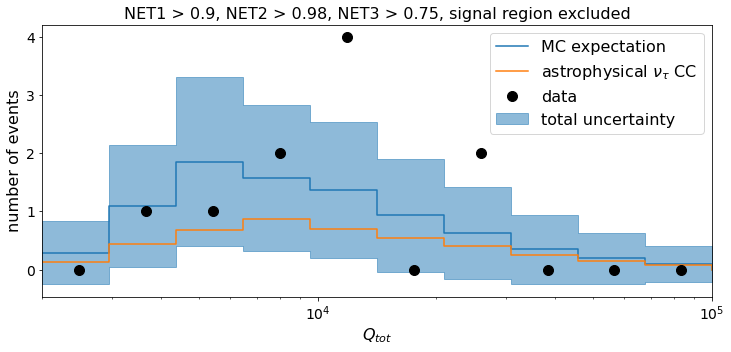

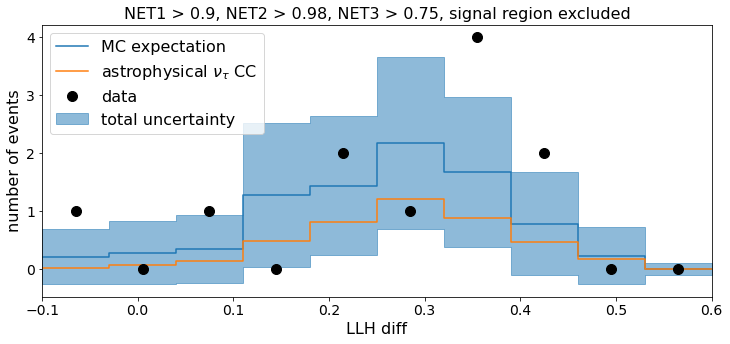

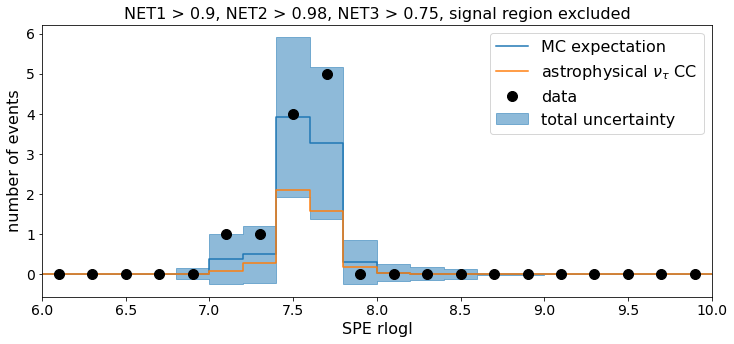

In [30]:
net_cuts = (0.9, 0.98, 0.75)
net_mask = build_net_mask(*net_cuts)
data_mc_stpos(data_df[net_mask][containment_mask], mc_df[net_mask][containment_mask])
plt.gcf().suptitle(f'net cuts = {net_cuts}, all preliminary cuts', fontsize=24, y=0.99)
plt.gcf().savefig('data_mc_plots/net3_positions.png', bbox_inches='tight')

data_mc_hists(*net_cuts, 'q_asym', '$Q_{asym}$', q_asym_bins, containment_mask)
plt.gcf().savefig('data_mc_plots/net3_qasym.png', bbox_inches='tight')
ax = data_mc_hists(*net_cuts, 'qtot', '$Q_{tot}$', qtot_bins, containment_mask)
ax.set_xscale('log')
plt.gcf().savefig('data_mc_plots/net3_qtot.png', bbox_inches='tight')
_ = data_mc_hists(*net_cuts, 'llh_diff', 'LLH diff', llh_diff_bins, containment_mask)
plt.gcf().savefig('data_mc_plots/net3_llh_diff.png', bbox_inches='tight')
_ = data_mc_hists(*net_cuts, 'spe_rlogl', 'SPE rlogl', rlogl_bins, containment_mask)
plt.gcf().savefig('data_mc_plots/net3_spe_rlogl.png', bbox_inches='tight')